In [1]:
import librosa 
from scipy.io import wavfile as wav
import numpy as np

filename = '../dataset/audio/ges.wav' 


librosa_audio, librosa_sample_rate = librosa.load(filename) 
scipy_sample_rate, scipy_audio = wav.read(filename) 

print('Original sample rate:', scipy_sample_rate) 
print('Librosa sample rate:', librosa_sample_rate) 

Original sample rate: 48000
Librosa sample rate: 22050


In [2]:
print('Original audio file min~max range:', np.min(scipy_audio), 'to', np.max(scipy_audio))
print('Librosa audio file min~max range:', np.min(librosa_audio), 'to', np.max(librosa_audio))

Original audio file min~max range: -6062 to 6181
Librosa audio file min~max range: -0.18454751 to 0.18106332


In [3]:
import matplotlib.pyplot as plt

# Original audio with 2 channels 
plt.figure(figsize=(12, 4))
plt.plot(scipy_audio)

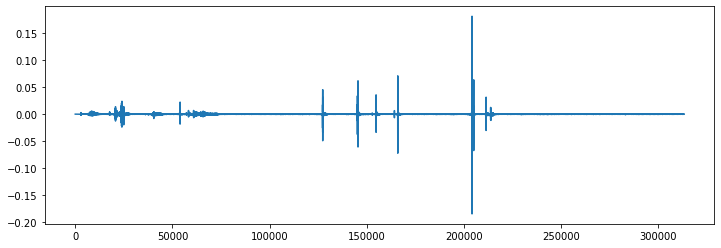

In [4]:
# Librosa audio with channels merged 
plt.figure(figsize=(12, 4))
plt.plot(librosa_audio)

In [5]:
mfccs = librosa.feature.mfcc(y=librosa_audio, sr=librosa_sample_rate, n_mfcc=40)
print(mfccs.shape)

(40, 612)


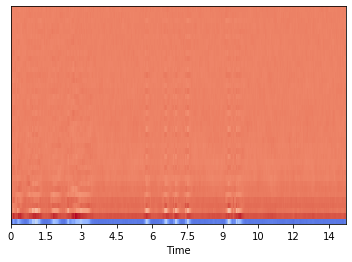

In [6]:
import librosa.display
librosa.display.specshow(mfccs, sr=librosa_sample_rate, x_axis='time')

In [7]:
def extract_features(file_name):
   
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfccsscaled = np.mean(mfccs.T,axis=0)
        
    except Exception as e:
        print("Error encountered while parsing file: ", file)
        return None 
     
    return mfccsscaled

In [8]:
# Load various imports 
import pandas as pd
import os
import librosa

# Set the path to the full UrbanSound dataset 
fulldatasetpath = '../dataset/audio/'

metadata = pd.read_csv('../dataset/dataset.csv')

features = []

# Iterate through each sound file and extract the features 
for index, row in metadata.iterrows():
    
    file_name = os.path.join(os.path.abspath(fulldatasetpath),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    
    class_label = row["class_name"]
    data = extract_features(file_name)
    
    features.append([data, class_label])

# Convert into a Panda dataframe 
featuresdf = pd.DataFrame(features, columns=['feature','class_label'])

print('Finished feature extraction from ', len(featuresdf), ' files') 

Finished feature extraction from  33  files


In [9]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Convert features and corresponding classification labels into numpy arrays
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())

# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y)) 

Using TensorFlow backend.


In [10]:
# split the dataset 
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 42)

In [11]:
### store the preprocessed data for use in the next notebook

%store x_train 
%store x_test 
%store y_train 
%store y_test 
%store yy 
%store le

Stored 'x_train' (ndarray)
Stored 'x_test' (ndarray)
Stored 'y_train' (ndarray)
Stored 'y_test' (ndarray)
Stored 'yy' (ndarray)
Stored 'le' (LabelEncoder)


In [12]:
# retrieve the preprocessed data from previous notebook

%store -r x_train 
%store -r x_test 
%store -r y_train 
%store -r y_test 
%store -r yy 
%store -r le

In [13]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 

num_labels = yy.shape[1]
filter_size = 2

# Construct model 
model = Sequential()

model.add(Dense(256, input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [14]:
# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam') 

In [15]:
# Display model architecture summary 
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=0)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               10496     
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
activation_2 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                

In [16]:
from keras.callbacks import ModelCheckpoint 
from datetime import datetime 

num_epochs = 100
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.basic_mlp.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Train on 26 samples, validate on 7 samples
Epoch 1/100
26/26 [==============================] - 0s 12ms/step - loss: 59.9702 - accuracy: 0.1923 - val_loss: 14.8495 - val_accuracy: 0.1429

Epoch 00001: val_loss improved from inf to 14.84950, saving model to saved_models/weights.best.basic_mlp.hdf5
Epoch 2/100
26/26 [==============================] - 0s 316us/step - loss: 58.1063 - accuracy: 0.1538 - val_loss: 1.9820 - val_accuracy: 0.5714

Epoch 00002: val_loss improved from 14.84950 to 1.98199, saving model to saved_models/weights.best.basic_mlp.hdf5
Epoch 3/100
26/26 [==============================] - 0s 158us/step - loss: 39.3153 - accuracy: 0.3846 - val_loss: 9.8265 - val_accuracy: 0.4286

Epoch 00003: val_loss did not improve from 1.98199
Epoch 4/100
26/26 [==============================] - 0s 133us/step - loss: 31.0585 - accuracy: 0.5000 - val_loss: 10.5694 - val_accuracy: 0.4286

Epoch 00004: val_loss did not improve from 1.98199
Epoch 5/100
26/26 [==============================]

Epoch 42/100
26/26 [==============================] - 0s 273us/step - loss: 12.1962 - accuracy: 0.5769 - val_loss: 2.8945 - val_accuracy: 0.4286

Epoch 00042: val_loss did not improve from 1.98199
Epoch 43/100
26/26 [==============================] - 0s 507us/step - loss: 16.5664 - accuracy: 0.3077 - val_loss: 2.2456 - val_accuracy: 0.4286

Epoch 00043: val_loss did not improve from 1.98199
Epoch 44/100
26/26 [==============================] - 0s 634us/step - loss: 7.7061 - accuracy: 0.6154 - val_loss: 1.5555 - val_accuracy: 0.4286

Epoch 00044: val_loss improved from 1.98199 to 1.55555, saving model to saved_models/weights.best.basic_mlp.hdf5
Epoch 45/100
26/26 [==============================] - 0s 233us/step - loss: 13.5919 - accuracy: 0.3846 - val_loss: 1.1910 - val_accuracy: 0.4286

Epoch 00045: val_loss improved from 1.55555 to 1.19102, saving model to saved_models/weights.best.basic_mlp.hdf5
Epoch 46/100
26/26 [==============================] - 0s 346us/step - loss: 13.3859 - acc


Epoch 00080: val_loss did not improve from 0.19320
Epoch 81/100
26/26 [==============================] - 0s 477us/step - loss: 5.3840 - accuracy: 0.7308 - val_loss: 0.6180 - val_accuracy: 0.5714

Epoch 00081: val_loss did not improve from 0.19320
Epoch 82/100
26/26 [==============================] - 0s 356us/step - loss: 3.9950 - accuracy: 0.7692 - val_loss: 0.7485 - val_accuracy: 0.5714

Epoch 00082: val_loss did not improve from 0.19320
Epoch 83/100
26/26 [==============================] - 0s 570us/step - loss: 1.5991 - accuracy: 0.7692 - val_loss: 0.7999 - val_accuracy: 0.5714

Epoch 00083: val_loss did not improve from 0.19320
Epoch 84/100
26/26 [==============================] - 0s 568us/step - loss: 4.6080 - accuracy: 0.6154 - val_loss: 0.6660 - val_accuracy: 0.5714

Epoch 00084: val_loss did not improve from 0.19320
Epoch 85/100
26/26 [==============================] - 0s 500us/step - loss: 4.6469 - accuracy: 0.6923 - val_loss: 0.5711 - val_accuracy: 0.5714

Epoch 00085: val_lo

In [17]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9230769276618958
Testing Accuracy:  0.8571428656578064


In [18]:
import librosa 
import numpy as np 

def extract_feature(file_name):
   
    try:
        audio_data, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=40)
        mfccsscaled = np.mean(mfccs.T,axis=0)
        
    except Exception as e:
        print("Error encountered while parsing file: ", file)
        return None, None

    return np.array([mfccsscaled])


In [19]:
def print_prediction(file_name):
    prediction_feature = extract_feature(file_name) 

    predicted_vector = model.predict_classes(prediction_feature)
    predicted_class = le.inverse_transform(predicted_vector) 
    print("The predicted class is:", predicted_class[0], '\n') 

    predicted_proba_vector = model.predict_proba(prediction_feature) 
    predicted_proba = predicted_proba_vector[0]
    for i in range(len(predicted_proba)): 
        category = le.inverse_transform(np.array([i]))
        print(category[0], "\t\t : ", format(predicted_proba[i], '.32f') )

In [22]:
# test

filename = '../dataset/audio/fb_tur.wav' 
print_prediction(filename) 

The predicted class is: facebook 

Instagram 		 :  0.00000000000200645099493468315188
facebook 		 :  0.99785906076431274414062500000000
whatsapp 		 :  0.00214093131944537162780761718750
